In [819]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

In [820]:
df = pd.read_csv('bike_sharing_data.csv')

In [821]:
# Look at the initial rows of dataset to get the feel of data
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


##  1. Dataset characteristics

bike_sharing_data.csv have the following fields:
	
	- instant: record index
	- dteday : date
	- season : season (1:spring, 2:summer, 3:fall, 4:winter)
	- yr : year (0: 2018, 1:2019)
	- mnth : month ( 1 to 12)
	- holiday : weather day is a holiday or not
	- weekday : day of the week
	- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
	+ weathersit : 
		- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
		- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
		- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
		- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
	- temp : temperature in Celsius
	- atemp: feeling temperature in Celsius
	- hum: humidity
	- windspeed: wind speed
	- casual: count of casual users
	- registered: count of registered users
	- cnt: count of total rental bikes including both casual and registered

In [822]:
# No null data in the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [823]:
# Checking the range of data on numeric columns
df.describe()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,365.500000,2.498630,0.500000,6.526027,0.028767,2.997260,0.683562,1.394521,20.319259,23.726322,62.765175,12.763620,849.249315,3658.757534,4508.006849
std,210.877136,1.110184,0.500343,3.450215,0.167266,2.006161,0.465405,0.544807,7.506729,8.150308,14.237589,5.195841,686.479875,1559.758728,1936.011647
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.424346,3.953480,0.000000,1.500244,2.000000,20.000000,22.000000
25%,183.250000,2.000000,0.000000,4.000000,0.000000,1.000000,0.000000,1.000000,13.811885,16.889713,52.000000,9.041650,316.250000,2502.250000,3169.750000
50%,365.500000,3.000000,0.500000,7.000000,0.000000,3.000000,1.000000,1.000000,20.465826,24.368225,62.625000,12.125325,717.000000,3664.500000,4548.500000
75%,547.750000,3.000000,1.000000,10.000000,0.000000,5.000000,1.000000,2.000000,26.880615,30.445775,72.989575,15.625589,1096.500000,4783.250000,5966.000000
max,730.000000,4.000000,1.000000,12.000000,1.000000,6.000000,1.000000,3.000000,35.328347,42.044800,97.250000,34.000021,3410.000000,6946.000000,8714.000000


In [824]:
# Check what values are present in "weathersit" column
print(df.weathersit.value_counts())

# Check what values are present in "season" column
print(df.season.value_counts())

weathersit
1    463
2    246
3     21
Name: count, dtype: int64
season
3    188
2    184
1    180
4    178
Name: count, dtype: int64


In [825]:
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


## 2. Data Cleaning

### 2.1 Dropping unwanted features

In [826]:
# Drop instant, dteday, casual, and registered columns from the dataframe.

# Because: 
# instant - unqiue id
# dteday - As we already have yr, mnth, weekday info in separate columns
# casual & registered - They are basically a breakup of cnt target variable (as different categories of bike bookers)

bike_data = df.iloc[:, 2:16]

In [827]:
bike_data

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,1,1,12,0,4,1,2,10.420847,11.33210,65.2917,23.458911,247,1867,2114
726,1,1,12,0,5,1,2,10.386653,12.75230,59.0000,10.416557,644,2451,3095
727,1,1,12,0,6,0,2,10.386653,12.12000,75.2917,8.333661,159,1182,1341
728,1,1,12,0,0,0,1,10.489153,11.58500,48.3333,23.500518,364,1432,1796


In [828]:
bike_data = bike_data.drop(columns=['casual', 'registered'], axis=1)

In [829]:
bike_data

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,1600
...,...,...,...,...,...,...,...,...,...,...,...,...
725,1,1,12,0,4,1,2,10.420847,11.33210,65.2917,23.458911,2114
726,1,1,12,0,5,1,2,10.386653,12.75230,59.0000,10.416557,3095
727,1,1,12,0,6,0,2,10.386653,12.12000,75.2917,8.333661,1341
728,1,1,12,0,0,0,1,10.489153,11.58500,48.3333,23.500518,1796


### 2.2 Creating categorical variables

In [830]:
# binary variables

bin_list = ['yr', 'holiday', 'workingday']

# categorical variables

cat_list = ['season', 'weathersit', 'mnth', 'weekday']

In [831]:
bike_data['weathersit'] = bike_data['weathersit'].map({1: 'Clear or Partly Cloudy', 2: 'Misty or Cloudy', 3: 'Light Rain or Snowy', 4: 'Heavy Rain or Snowy'})

bike_data['season'] = bike_data['season'].map({1: 'Spring', 2: 'Summer', 3: 'Fall', 4: 'Winter'})

bike_data['mnth'] = bike_data['mnth'].map({1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep',
                                        10: 'Oct', 11: 'Nov', 12: 'Dec'})

bike_data['weekday'] = bike_data['weekday'].map({0: 'Sun', 1: 'Mon', 2: 'Tue', 3: 'Wed', 4: 'Thu', 5: 'Fri', 6: 'Sat'})

bike_data.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,Spring,0,Jan,0,Sat,0,Misty or Cloudy,14.110847,18.18125,80.5833,10.749882,985
1,Spring,0,Jan,0,Sun,0,Misty or Cloudy,14.902598,17.68695,69.6087,16.652113,801
2,Spring,0,Jan,0,Mon,1,Clear or Partly Cloudy,8.050924,9.47025,43.7273,16.636703,1349
3,Spring,0,Jan,0,Tue,1,Clear or Partly Cloudy,8.200000,10.60610,59.0435,10.739832,1562
4,Spring,0,Jan,0,Wed,1,Clear or Partly Cloudy,9.305237,11.46350,43.6957,12.522300,1600


### 2.3 Creating dummies for categorical features

In [833]:
bike_data[cat_list] = bike_data[cat_list].astype('category')

dummies = pd.get_dummies(bike_data[cat_list], dtype=int, drop_first=True, prefix=None)
dummies

,season_Spring,season_Summer,season_Winter,weathersit_Light Rain or Snowy,weathersit_Misty or Cloudy,mnth_Aug,mnth_Dec,mnth_Feb,mnth_Jan,mnth_Jul,...,mnth_May,mnth_Nov,mnth_Oct,mnth_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed
0,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,1,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0
2,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
3,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,1,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
726,1,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
727,1,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
728,1,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [834]:
bike_data = pd.concat([bike_data,dummies], axis=1)

In [835]:
bike_data.columns

Index(['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday',
       'weathersit', 'temp', 'atemp', 'hum', 'windspeed', 'cnt',
       'season_Spring', 'season_Summer', 'season_Winter',
       'weathersit_Light Rain or Snowy', 'weathersit_Misty or Cloudy',
       'mnth_Aug', 'mnth_Dec', 'mnth_Feb', 'mnth_Jan', 'mnth_Jul', 'mnth_Jun',
       'mnth_Mar', 'mnth_May', 'mnth_Nov', 'mnth_Oct', 'mnth_Sep',
       'weekday_Mon', 'weekday_Sat', 'weekday_Sun', 'weekday_Thu',
       'weekday_Tue', 'weekday_Wed'],
      dtype='object')

In [836]:
bike_data

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,...,mnth_May,mnth_Nov,mnth_Oct,mnth_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed
0,Spring,0,Jan,0,Sat,0,Misty or Cloudy,14.110847,18.18125,80.5833,...,0,0,0,0,0,1,0,0,0,0
1,Spring,0,Jan,0,Sun,0,Misty or Cloudy,14.902598,17.68695,69.6087,...,0,0,0,0,0,0,1,0,0,0
2,Spring,0,Jan,0,Mon,1,Clear or Partly Cloudy,8.050924,9.47025,43.7273,...,0,0,0,0,1,0,0,0,0,0
3,Spring,0,Jan,0,Tue,1,Clear or Partly Cloudy,8.200000,10.60610,59.0435,...,0,0,0,0,0,0,0,0,1,0
4,Spring,0,Jan,0,Wed,1,Clear or Partly Cloudy,9.305237,11.46350,43.6957,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,Spring,1,Dec,0,Thu,1,Misty or Cloudy,10.420847,11.33210,65.2917,...,0,0,0,0,0,0,0,1,0,0
726,Spring,1,Dec,0,Fri,1,Misty or Cloudy,10.386653,12.75230,59.0000,...,0,0,0,0,0,0,0,0,0,0
727,Spring,1,Dec,0,Sat,0,Misty or Cloudy,10.386653,12.12000,75.2917,...,0,0,0,0,0,1,0,0,0,0
728,Spring,1,Dec,0,Sun,0,Clear or Partly Cloudy,10.489153,11.58500,48.3333,...,0,0,0,0,0,0,1,0,0,0


In [837]:
bike_data = bike_data.drop(cat_list, axis=1)

In [838]:
bike_data

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_Spring,season_Summer,...,mnth_May,mnth_Nov,mnth_Oct,mnth_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed
0,0,0,0,14.110847,18.18125,80.5833,10.749882,985,1,0,...,0,0,0,0,0,1,0,0,0,0
1,0,0,0,14.902598,17.68695,69.6087,16.652113,801,1,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,1,8.050924,9.47025,43.7273,16.636703,1349,1,0,...,0,0,0,0,1,0,0,0,0,0
3,0,0,1,8.200000,10.60610,59.0435,10.739832,1562,1,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,1,9.305237,11.46350,43.6957,12.522300,1600,1,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,1,0,1,10.420847,11.33210,65.2917,23.458911,2114,1,0,...,0,0,0,0,0,0,0,1,0,0
726,1,0,1,10.386653,12.75230,59.0000,10.416557,3095,1,0,...,0,0,0,0,0,0,0,0,0,0
727,1,0,0,10.386653,12.12000,75.2917,8.333661,1341,1,0,...,0,0,0,0,0,1,0,0,0,0
728,1,0,0,10.489153,11.58500,48.3333,23.500518,1796,1,0,...,0,0,0,0,0,0,1,0,0,0


## 4. EDA

### 4.1 Univariate Analysis

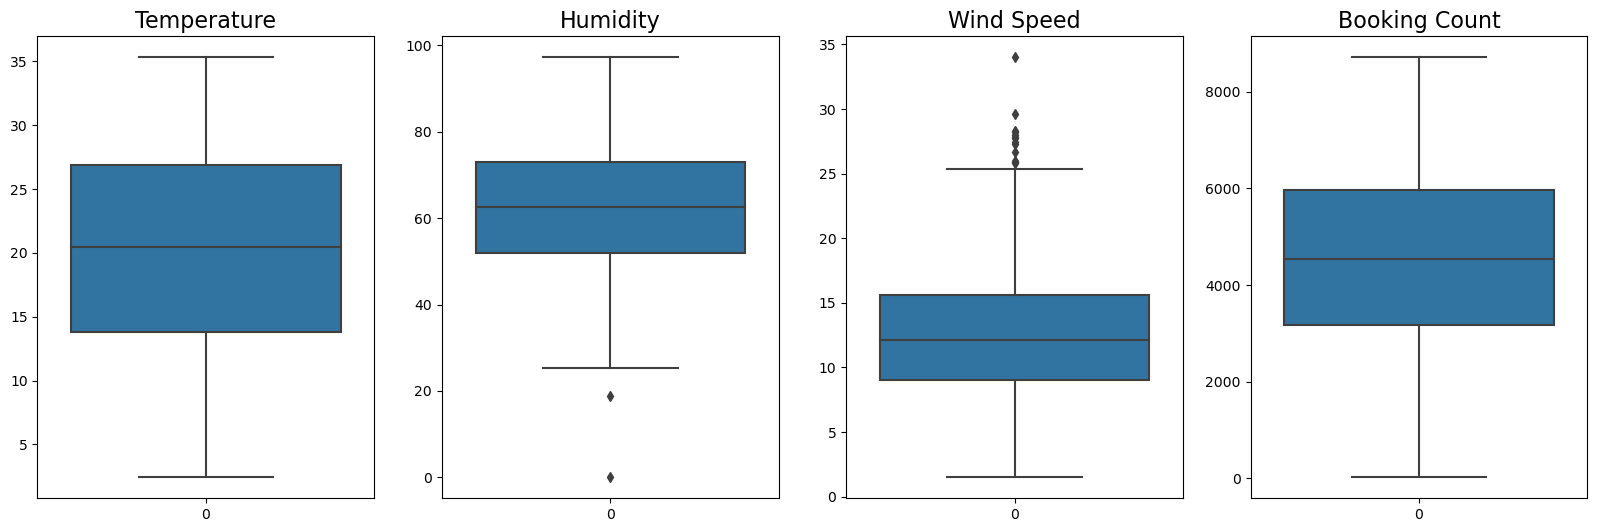

In [914]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(20,6))

sns.boxplot(data=bike_data['temp'], ax=ax[0])
sns.boxplot(data=bike_data['hum'], ax=ax[1])
sns.boxplot(data=bike_data['windspeed'], ax=ax[2])
sns.boxplot(data=bike_data['cnt'], ax=ax[3])

ax[0].set_title('Temperature', fontsize=16)
ax[1].set_title('Humidity', fontsize=16)
ax[2].set_title('Wind Speed', fontsize=16)
ax[3].set_title('Booking Count', fontsize=16)
plt.show()

### 3.2 Bivariate Analysis

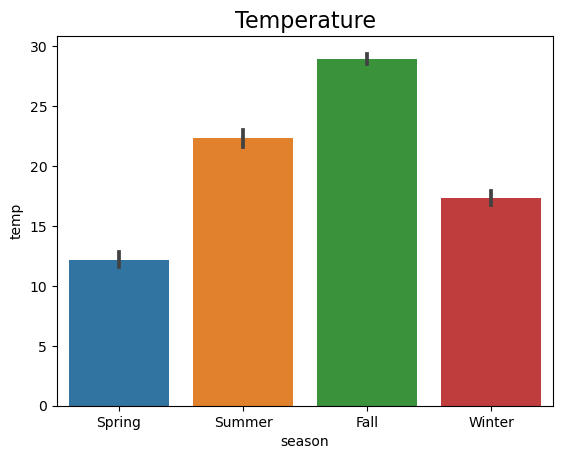

In [937]:
# Analysing temprature against season

bp = sns.barplot(x=df.season, y=df.temp)
bp.set_title('Temperature', fontsize=16)
labels = bp.get_xticklabels()
labels = [('Spring' if x.get_text() == '1' else ('Summer' if x.get_text() == '2' else ('Fall' if x.get_text() == '3' else 'Winter'))) for x in labels]
bp.set_xticklabels(labels)

plt.show()

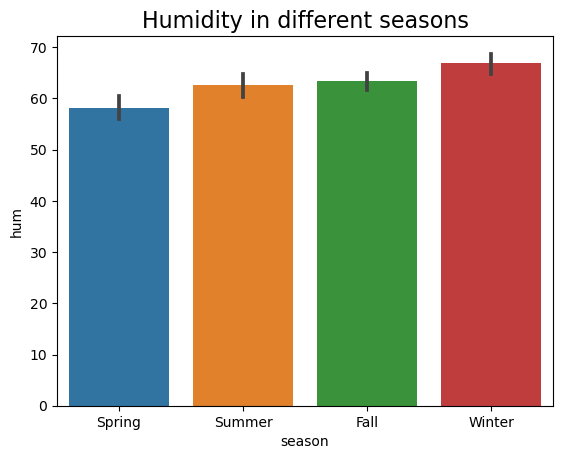

In [939]:
# Analysing humidity against season

bp = sns.barplot(x=df.season, y=df.hum)
bp.set_title('Humidity in different seasons', fontsize=16)
labels = bp.get_xticklabels()
labels = [('Spring' if x.get_text() == '1' else ('Summer' if x.get_text() == '2' else ('Fall' if x.get_text() == '3' else 'Winter'))) for x in labels]
bp.set_xticklabels(labels)

plt.show()

### 3.3 Multivariate Analysis

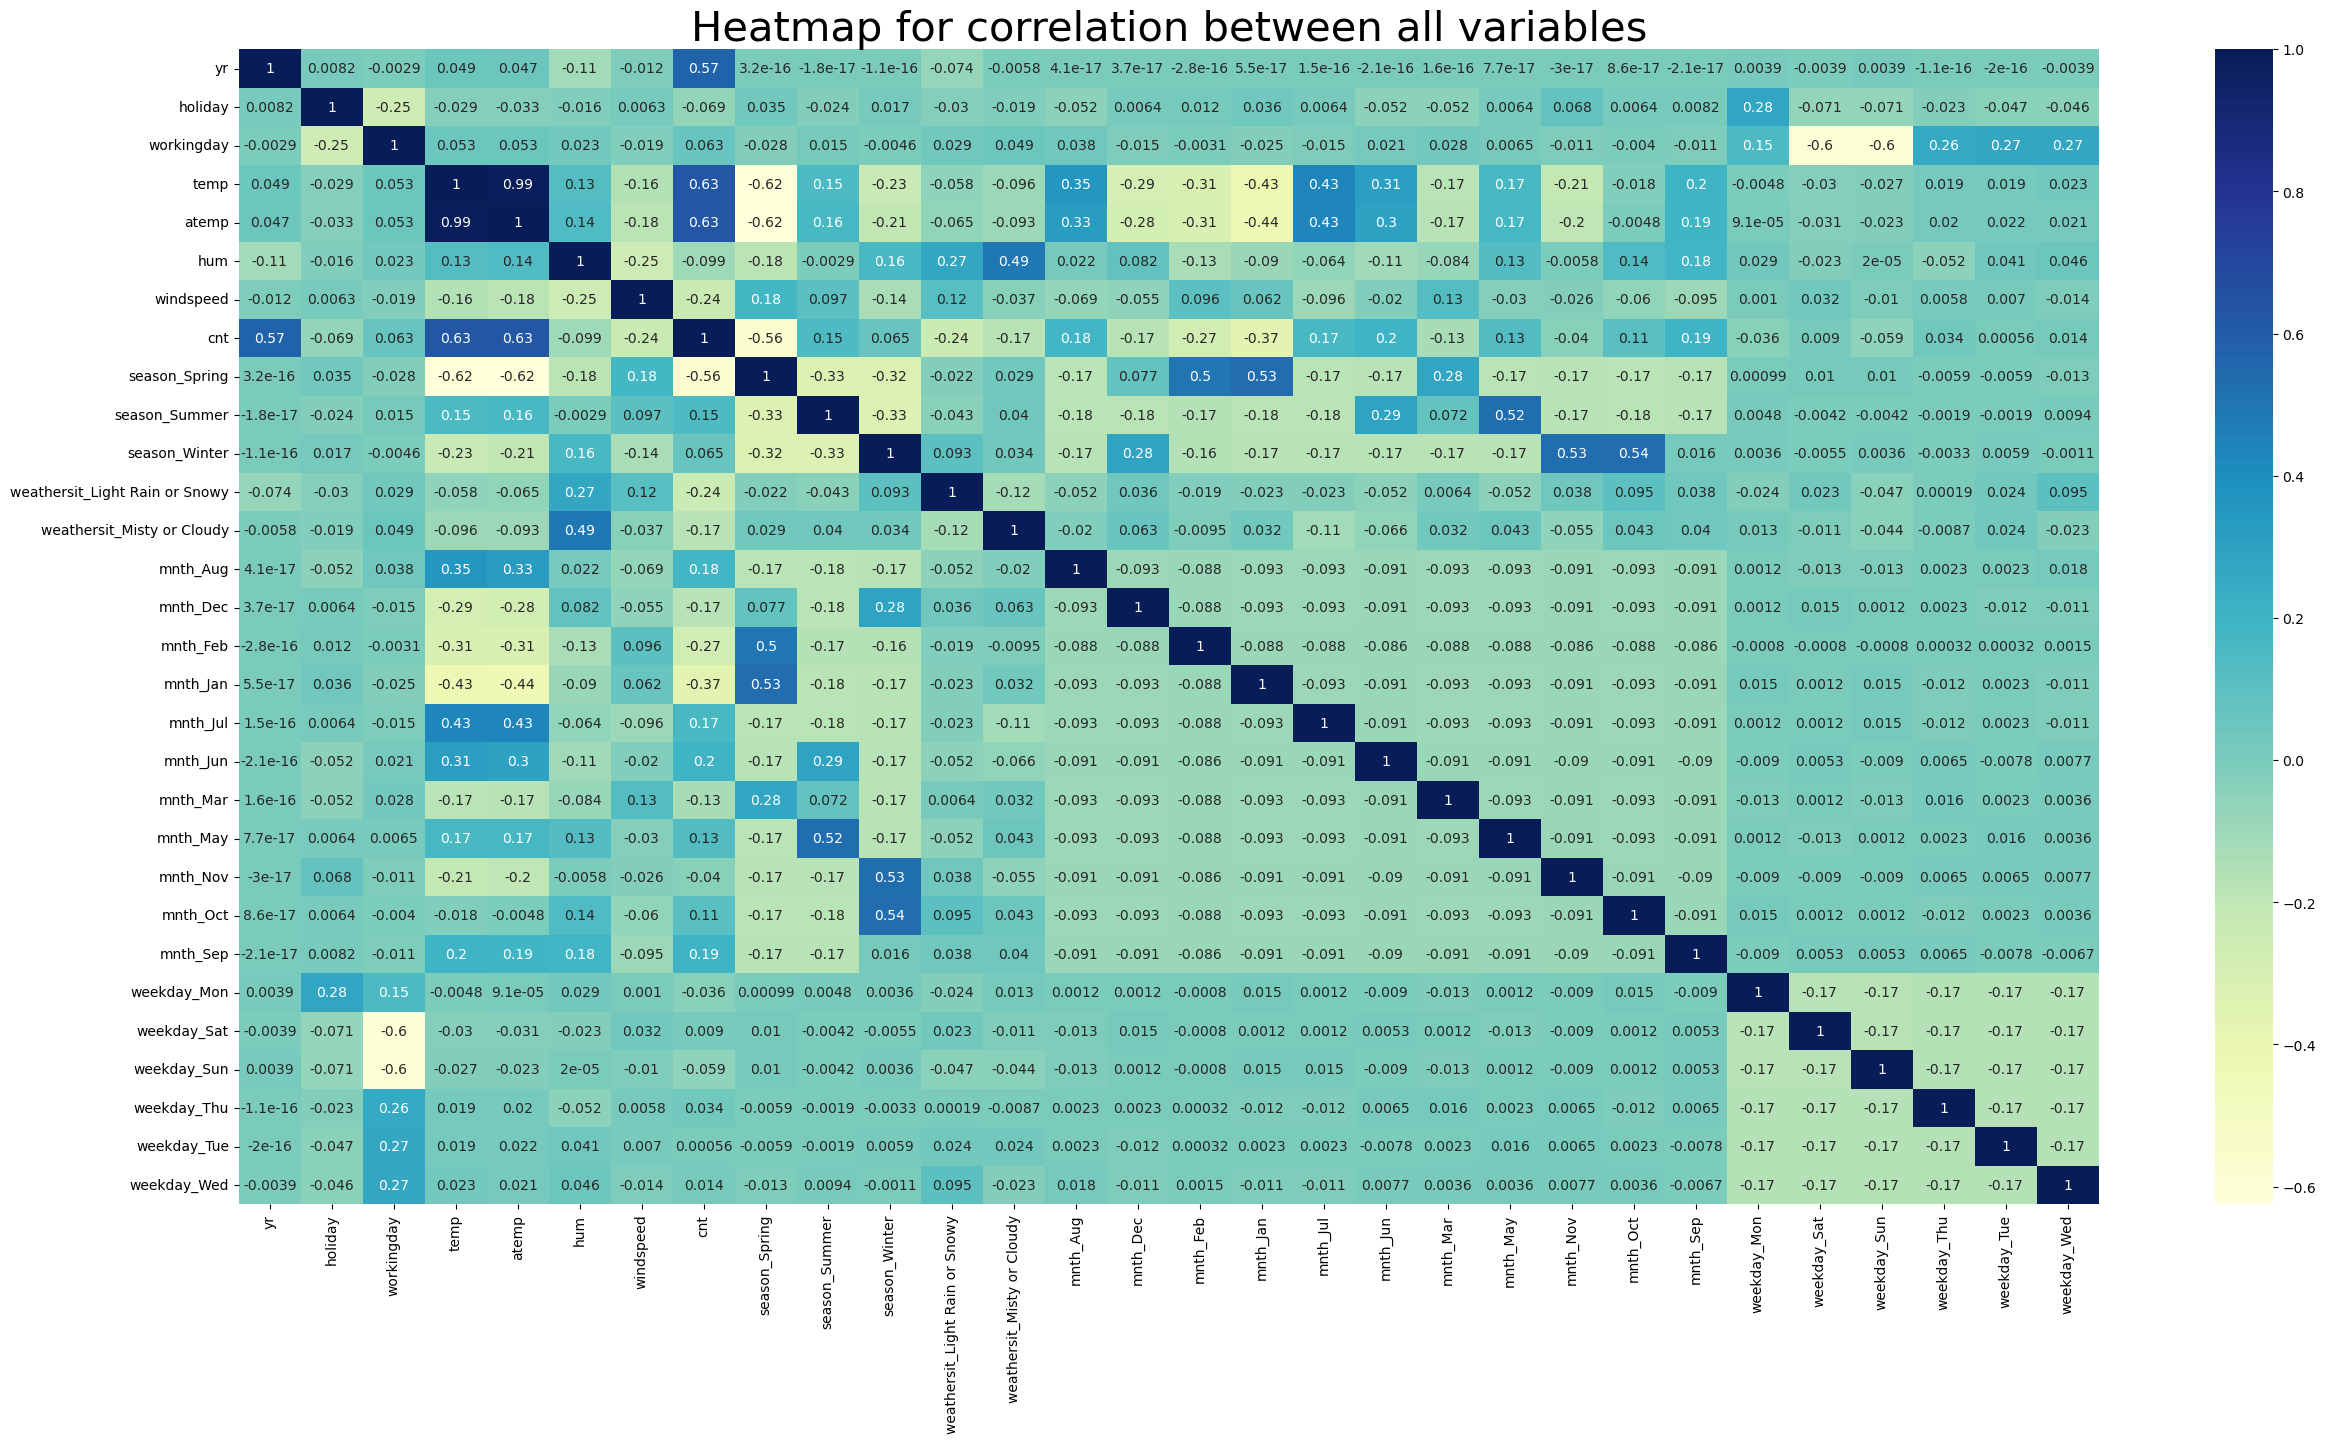

In [942]:
plt.figure(figsize = (30,15))
hm = sns.heatmap(bike_data.corr(), annot=True, cmap='YlGnBu')
hm.set_title('Heatmap for correlation between all variables', fontsize=30)
plt.show()

#### Conclusion: 

- Data is uniformly distributed with not many outliers
- Temperature and Humidity are more in fall and winter respectively
- cnt variable is highly correlated with temp, atemp, and yr features

## 4. Splitting data into train and test set

In [839]:
df_train, df_test = train_test_split(bike_data, train_size=0.7, random_state=100)

In [840]:
print(df_train.shape)
print(df_test.shape)

(510, 30)
(220, 30)


## 5. Build Linear Regression Model

### 5.1 Rescale the Features

In [841]:
# create a list of numeric vars
scaler = MinMaxScaler()

num_vars = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']

# Fit on data
df_train[num_vars] = scaler.fit_transform(df_train[num_vars])

In [842]:
df_train.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_Spring,season_Summer,...,mnth_May,mnth_Nov,mnth_Oct,mnth_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed
count,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,...,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000,510.000000
mean,0.507843,0.025490,0.676471,0.537440,0.513156,0.650480,0.320883,0.513499,0.243137,0.247059,...,0.084314,0.086275,0.084314,0.080392,0.150980,0.154902,0.143137,0.133333,0.131373,0.158824
std,0.500429,0.157763,0.468282,0.225858,0.212410,0.145846,0.169803,0.224421,0.429398,0.431725,...,0.278131,0.281045,0.278131,0.272166,0.358381,0.362166,0.350557,0.340268,0.338139,0.365870
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.339853,0.332086,0.538643,0.199179,0.356420,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.000000,0.000000,1.000000,0.542596,0.529718,0.653714,0.296763,0.518638,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.735215,0.688457,0.754830,0.414447,0.684710,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [844]:
y_train = df_train.pop('cnt')
print(y_train.head())
X_train = df_train
print(X_train.head())

576    0.827658
426    0.465255
728    0.204096
482    0.482973
111    0.191095
Name: cnt, dtype: float64
     yr  holiday  workingday      temp     atemp       hum  windspeed  \
576   1        0           1  0.815169  0.766351  0.725633   0.264686   
426   1        0           0  0.442393  0.438975  0.640189   0.255342   
728   1        0           0  0.245101  0.200348  0.498067   0.663106   
482   1        0           0  0.395666  0.391735  0.504508   0.188475   
111   0        0           1  0.345824  0.318819  0.751824   0.380981   

     season_Spring  season_Summer  season_Winter  ...  mnth_May  mnth_Nov  \
576              0              0              0  ...         0         0   
426              1              0              0  ...         0         0   
728              1              0              0  ...         0         0   
482              0              1              0  ...         0         0   
111              0              1              0  ...         0       

### 5.2 Feature Selection via RFE

In [845]:
# Create an instance of LR model
lm = LinearRegression()

# Fitting model on X_train, y_train
lm.fit(X_train, y_train)

# Creating RFE instance on fitted LM
rfe = RFE(estimator=lm, n_features_to_select=15)

# Converting rfe to fitted rfe
rfe = rfe.fit(X_train, y_train)

In [846]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('yr', True, 1),
 ('holiday', True, 1),
 ('workingday', True, 1),
 ('temp', True, 1),
 ('atemp', False, 5),
 ('hum', True, 1),
 ('windspeed', True, 1),
 ('season_Spring', True, 1),
 ('season_Summer', True, 1),
 ('season_Winter', True, 1),
 ('weathersit_Light Rain or Snowy', True, 1),
 ('weathersit_Misty or Cloudy', True, 1),
 ('mnth_Aug', False, 7),
 ('mnth_Dec', False, 3),
 ('mnth_Feb', False, 4),
 ('mnth_Jan', True, 1),
 ('mnth_Jul', True, 1),
 ('mnth_Jun', False, 14),
 ('mnth_Mar', False, 15),
 ('mnth_May', False, 6),
 ('mnth_Nov', False, 2),
 ('mnth_Oct', False, 13),
 ('mnth_Sep', True, 1),
 ('weekday_Mon', False, 9),
 ('weekday_Sat', True, 1),
 ('weekday_Sun', False, 8),
 ('weekday_Thu', False, 11),
 ('weekday_Tue', False, 10),
 ('weekday_Wed', False, 12)]

In [847]:
# Create a df
temp_rfe_df = pd.DataFrame()

# Add X_train columns to it
temp_rfe_df['features'] = X_train.columns

# Add rfe.support_

temp_rfe_df['rfe_support'] = rfe.support_

# Retain only those features which are recommended by model

temp_rfe_df = temp_rfe_df[temp_rfe_df['rfe_support'] == True]

temp_rfe_df

,features,rfe_support
0,yr,True
1,holiday,True
2,workingday,True
3,temp,True
5,hum,True
6,windspeed,True
7,season_Spring,True
8,season_Summer,True
9,season_Winter,True
10,weathersit_Light Rain or Snowy,True


In [848]:
# create an array of selected features

features = [f for f in temp_rfe_df['features']]

# Update X_train

X_train = X_train[features]

### 5.3 Train the model and eliminate insignificant features & features with multicollinearity

#### 5.3.1 Function for OLS model

In [849]:
def linreg_ols_model(y_df, X_df):

    # Add a constant

    X_train_sm = sm.add_constant(X_df)

    # Perform Linear Regression
    lr = sm.OLS(y_df, X_train_sm).fit()

    # params of lr model
    print(lr.summary())
    
linreg_ols_model(y_train, X_train)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     184.0
Date:                Sat, 29 Jun 2024   Prob (F-statistic):          4.22e-191
Time:                        14:57:26   Log-Likelihood:                 519.65
No. Observations:                 510   AIC:                            -1007.
Df Residuals:                     494   BIC:                            -939.5
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

#### 5.3.2 Function for Variance Inflation Factor (VIF)

In [850]:
def vif(dataframe):
    vif = pd.DataFrame()
    vif['Features'] = dataframe.columns
    vif['VIF'] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    vif['VIF'] = round(vif['VIF'], 2)
    vif = vif.sort_values(by = "VIF", ascending= False)
    return vif

vif(X_train)

,Features,VIF
4,hum,29.37
3,temp,17.78
2,workingday,5.31
5,windspeed,4.73
6,season_Spring,4.53
8,season_Winter,3.46
7,season_Summer,2.85
10,weathersit_Misty or Cloudy,2.29
0,yr,2.09
14,weekday_Sat,1.98


In [851]:
# Model 2
# Remove mnth_Jan as it has high p value & low VIF
X_train_1 = X_train.drop('mnth_Jan', axis=1)
# X_train_1
linreg_ols_model(y_train, X_train_1)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     195.7
Date:                Sat, 29 Jun 2024   Prob (F-statistic):          2.11e-191
Time:                        14:59:22   Log-Likelihood:                 517.61
No. Observations:                 510   AIC:                            -1005.
Df Residuals:                     495   BIC:                            -941.7
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [852]:
vif(X_train_1)

,Features,VIF
4,hum,28.46
3,temp,16.98
2,workingday,5.28
5,windspeed,4.72
6,season_Spring,4.24
8,season_Winter,3.42
7,season_Summer,2.85
10,weathersit_Misty or Cloudy,2.29
0,yr,2.08
13,weekday_Sat,1.97


In [853]:
# Model 3
# Remove hum as it has high VIF
X_train_2 = X_train_1.drop('hum', axis=1)
# X_train_1
linreg_ols_model(y_train, X_train_2)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     202.2
Date:                Sat, 29 Jun 2024   Prob (F-statistic):          1.28e-188
Time:                        14:59:56   Log-Likelihood:                 508.20
No. Observations:                 510   AIC:                            -988.4
Df Residuals:                     496   BIC:                            -929.1
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [854]:
vif(X_train_2)

,Features,VIF
3,temp,6.97
2,workingday,5.20
4,windspeed,4.65
5,season_Spring,2.49
6,season_Summer,2.34
0,yr,2.07
7,season_Winter,1.98
12,weekday_Sat,1.96
10,mnth_Jul,1.58
9,weathersit_Misty or Cloudy,1.57


In [856]:
# Model 4
# Remove mnth_July as it has significant p value & low VIF
X_train_3 = X_train_2.drop('mnth_Jul', axis=1)
# X_train_1
linreg_ols_model(y_train, X_train_3)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     215.7
Date:                Sat, 29 Jun 2024   Prob (F-statistic):          3.16e-188
Time:                        15:00:45   Log-Likelihood:                 504.48
No. Observations:                 510   AIC:                            -983.0
Df Residuals:                     497   BIC:                            -927.9
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [857]:
vif(X_train_3)

,Features,VIF
3,temp,5.70
2,workingday,5.20
4,windspeed,4.65
5,season_Spring,2.40
0,yr,2.07
6,season_Summer,2.01
11,weekday_Sat,1.96
7,season_Winter,1.83
9,weathersit_Misty or Cloudy,1.57
10,mnth_Sep,1.24


In [858]:
# Model 5
# Remove holiday as it has high p value & low VIF
X_train_4 = X_train_3.drop('holiday', axis=1)
# X_train_1
linreg_ols_model(y_train, X_train_4)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.838
Model:                            OLS   Adj. R-squared:                  0.834
Method:                 Least Squares   F-statistic:                     233.6
Date:                Sat, 29 Jun 2024   Prob (F-statistic):          1.42e-188
Time:                        15:02:40   Log-Likelihood:                 502.47
No. Observations:                 510   AIC:                            -980.9
Df Residuals:                     498   BIC:                            -930.1
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [859]:
vif(X_train_4)

,Features,VIF
2,temp,5.48
1,workingday,4.66
3,windspeed,4.64
4,season_Spring,2.30
0,yr,2.07
5,season_Summer,2.00
10,weekday_Sat,1.83
6,season_Winter,1.76
8,weathersit_Misty or Cloudy,1.57
9,mnth_Sep,1.23


In [860]:
# Model 6
# Remove season_Spring as it has significant p value & lower VIF
X_train_5 = X_train_4.drop('season_Spring', axis=1)
# X_train_1
linreg_ols_model(y_train, X_train_5)

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.835
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     253.0
Date:                Sat, 29 Jun 2024   Prob (F-statistic):          3.13e-188
Time:                        15:03:21   Log-Likelihood:                 498.79
No. Observations:                 510   AIC:                            -975.6
Df Residuals:                     499   BIC:                            -929.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

In [861]:
vif(X_train_5)

,Features,VIF
2,temp,4.76
1,workingday,4.04
3,windspeed,3.44
0,yr,2.02
9,weekday_Sat,1.69
4,season_Summer,1.57
7,weathersit_Misty or Cloudy,1.53
5,season_Winter,1.40
8,mnth_Sep,1.20
6,weathersit_Light Rain or Snowy,1.08


### 5.4 Residual Analysis

In [862]:
X_train_res = sm.add_constant(X_train_5)
lm = sm.OLS(y_train, X_train_res).fit()

y_train_pred = lm.predict(X_train_res)

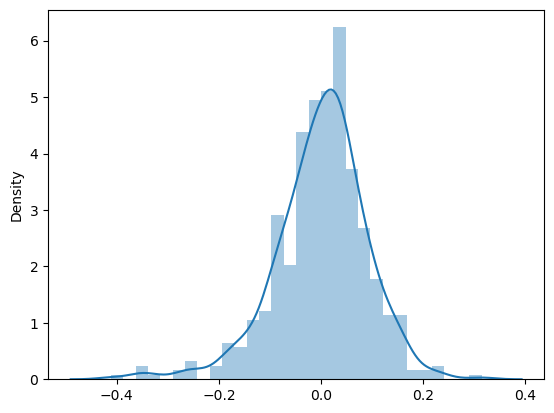

In [863]:
residuals = y_train - y_train_pred
sns.distplot(residuals)
plt.show()

Text(0.5, 0, 'y Train Predictions')

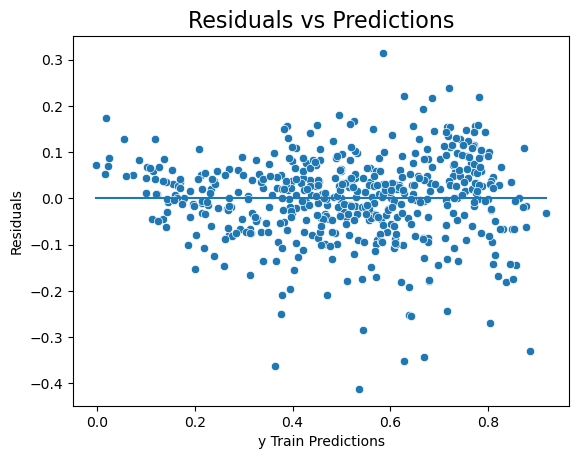

In [944]:
chart = sns.scatterplot(y=residuals.values, x=y_train_pred.values, palette='Purples')
sns.lineplot(y=residuals.mean(), x=y_train_pred.values, palette='Purples')

chart.set_title('Residuals vs Predictions', fontsize=16)
chart.set_ylabel('Residuals')
chart.set_xlabel('y Train Predictions')

### 5.5 Testing for Homoscedasticity

Text(0.5, 0, 'Predictions')

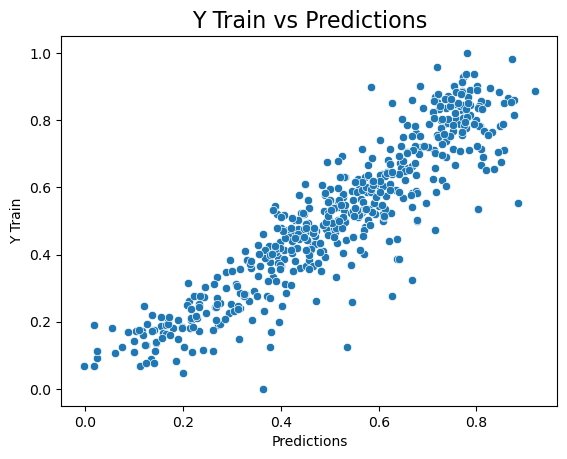

In [943]:
chart = sns.scatterplot(y=y_train, x=y_train_pred.values, palette='Purples')

chart.set_title('Y Train vs Predictions', fontsize=16)
chart.set_ylabel('Y Train')
chart.set_xlabel('Predictions')

#### Conclision:

- All multiple linear regression model assumptions stay satisfied

### Predictions & Evaluation on Test Set

In [864]:
num_vars = ['temp', 'atemp', 'hum', 'windspeed', 'cnt']

# Normalizing test set numerical variables

df_test[num_vars] = scaler.transform(df_test[num_vars])
df_test.head()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_Spring,season_Summer,...,mnth_May,mnth_Nov,mnth_Oct,mnth_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed
184,0,1,0,0.831783,0.769660,0.657364,0.084219,0.692706,0,0,...,0,0,0,0,1,0,0,0,0,0
535,1,0,1,0.901354,0.842587,0.610133,0.153728,0.712034,0,1,...,0,0,0,0,0,0,0,0,0,1
299,0,0,1,0.511964,0.496145,0.837699,0.334206,0.303382,0,0,...,0,0,1,0,0,0,0,1,0,0
221,0,0,1,0.881625,0.795343,0.437098,0.339570,0.547400,0,0,...,0,0,0,0,0,0,0,0,0,1
152,0,0,1,0.817246,0.741471,0.314298,0.537414,0.569029,0,1,...,0,0,0,0,0,0,0,1,0,0


In [865]:
df_test.describe()

,yr,holiday,workingday,temp,atemp,hum,windspeed,cnt,season_Spring,season_Summer,...,mnth_May,mnth_Nov,mnth_Oct,mnth_Sep,weekday_Mon,weekday_Sat,weekday_Sun,weekday_Thu,weekday_Tue,weekday_Wed
count,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,...,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000,220.000000
mean,0.481818,0.036364,0.700000,0.558718,0.532847,0.638221,0.313293,0.522154,0.254545,0.263636,...,0.086364,0.072727,0.086364,0.086364,0.127273,0.118182,0.145455,0.163636,0.168182,0.100000
std,0.500809,0.187620,0.459303,0.233187,0.217401,0.148694,0.159584,0.219163,0.436599,0.441609,...,0.281541,0.260281,0.281541,0.281541,0.334038,0.323559,0.353363,0.370789,0.374881,0.300684
min,0.000000,0.000000,0.000000,0.046591,0.025950,0.261915,-0.042808,0.048205,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.355429,0.344870,0.529197,0.198843,0.378595,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,1.000000,0.558172,0.544652,0.625590,0.300126,0.524678,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,0.755981,0.713308,0.743798,0.402718,0.677750,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,0.984424,0.980934,1.002146,0.807474,0.963300,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [866]:
y_test = df_test.pop('cnt')
X_test = df_test

In [867]:
model_cols = [f for f in X_train_5]

In [868]:
X_test = X_test[model_cols]
X_test

,yr,workingday,temp,windspeed,season_Summer,season_Winter,weathersit_Light Rain or Snowy,weathersit_Misty or Cloudy,mnth_Sep,weekday_Sat
184,0,0,0.831783,0.084219,0,0,0,1,0,0
535,1,1,0.901354,0.153728,1,0,0,0,0,0
299,0,1,0.511964,0.334206,0,1,0,1,0,0
221,0,1,0.881625,0.339570,0,0,0,0,0,0
152,0,1,0.817246,0.537414,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
702,1,1,0.519232,0.283397,0,1,0,0,0,0
127,0,0,0.584649,0.069510,1,0,0,0,0,0
640,1,1,0.745598,0.052115,0,1,0,1,0,0
72,0,1,0.331557,0.203418,0,0,0,0,0,0


In [869]:
X_test_sm = sm.add_constant(X_test)
X_test_sm

,const,yr,workingday,temp,windspeed,season_Summer,season_Winter,weathersit_Light Rain or Snowy,weathersit_Misty or Cloudy,mnth_Sep,weekday_Sat
184,1.0,0,0,0.831783,0.084219,0,0,0,1,0,0
535,1.0,1,1,0.901354,0.153728,1,0,0,0,0,0
299,1.0,0,1,0.511964,0.334206,0,1,0,1,0,0
221,1.0,0,1,0.881625,0.339570,0,0,0,0,0,0
152,1.0,0,1,0.817246,0.537414,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
702,1.0,1,1,0.519232,0.283397,0,1,0,0,0,0
127,1.0,0,0,0.584649,0.069510,1,0,0,0,0,0
640,1.0,1,1,0.745598,0.052115,0,1,0,1,0,0
72,1.0,0,1,0.331557,0.203418,0,0,0,0,0,0


In [878]:
y_test_pred = lm.predict(X_test_sm)
print(y_test)
print(y_test_pred)

184    0.692706
535    0.712034
299    0.303382
221    0.547400
152    0.569029
         ...   
702    0.757478
127    0.495973
640    0.868615
72     0.232858
653    0.864243
Name: cnt, Length: 220, dtype: float64
184    0.439308
535    0.924675
299    0.411415
221    0.563224
152    0.585737
         ...   
702    0.736458
127    0.474336
640    0.816810
72     0.281876
653    0.728620
Length: 220, dtype: float64


### Generalization Capability

In [895]:
test_r2 = r2_score(y_true=y_test, y_pred=y_test_pred)
train_r2 = r2_score(y_true=y_train, y_pred=y_train_pred)
difference = (train_r2 - test_r2) * 100
difference

3.9135915723590764

#### Since the variation between train & test model predictions is < 5%, the model seems to have generalized well

### 5.6 Model Equation



In [955]:
model_params = pd.Series(lm.params)
model_params

const                             0.075009
yr                                0.233139
workingday                        0.056117
temp                              0.549892
windspeed                        -0.155203
season_Summer                     0.088621
season_Winter                     0.130655
weathersit_Light Rain or Snowy   -0.287090
weathersit_Misty or Cloudy       -0.080022
mnth_Sep                          0.097365
weekday_Sat                       0.067500
dtype: float64

In [956]:
for i in range(len(model_params)):
    if (i == 0):
        print(f'Bike Demand = {round(model_params.const,4)}')
    elif i != len(model_params)-1 and i !=0:
        print(f'\t {model_params.index[i]} x {round(model_params.values[i], 4)} + ')
    else:
        print(f'\t {model_params.index[i]} x {round(model_params.values[i], 4)}')

Bike Demand = 0.075
	 yr x 0.2331 + 
	 workingday x 0.0561 + 
	 temp x 0.5499 + 
	 windspeed x -0.1552 + 
	 season_Summer x 0.0886 + 
	 season_Winter x 0.1307 + 
	 weathersit_Light Rain or Snowy x -0.2871 + 
	 weathersit_Misty or Cloudy x -0.08 + 
	 mnth_Sep x 0.0974 + 
	 weekday_Sat x 0.0675


### Final Note

- Constant is 0.075, implying if all features are kept 0, the demand will be 0.075.
- Coefficients of yr, workingday, temp, Summer, Winter, Sep, and Sat are positive
- Coefficients of windspeed, Light Rain or Snowy, and Misty or Cloudy are negetive